In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
1920*4, 1080*4

(7680, 4320)

In [3]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [ ]:
import RaTag.dataIO as dataIO 
from RaTag.datatypes import *
import RaTag.config as config
import RaTag.transport as transport
import RaTag.plotting as plotting
import RaTag.constructors as constructors
import RaTag.analysis as analysis
import RaTag.transformations as transf
from RaTag.xray_integration import *

In [5]:
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec')

# Test x-rays module

In [5]:
file_ff = '/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN8_20250903_Gate500_Anode2400_P6_1Wfm.wfm'
wfm_ff = dataIO.load_wfm(file_ff)
wfm_ff.ff

True

In [ ]:
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec')
meas_path = base_dir / 'FieldScan_Gate050_Anode1950'
# look into wfm 7319
wfm_paths = sorted(meas_path.glob('*.wfm'))
wfm_paths[:3]
i = 0
j = -1

In [7]:
t_s1 = -3.0
s2_start = 14


(10, 45)

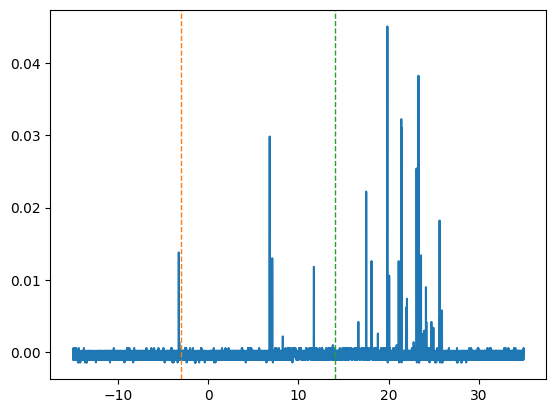

In [529]:
wf = dataIO.load_wfm(wfm_paths[i])
j += 1
Vi = wf.v[j, :]
wf.t *= 1e6  # to us
plt.plot(wf.t, Vi);
plt.axvline(t_s1, color='C1', ls='--', lw=1)
plt.axvline(s2_start, color='C2', ls='--', lw=1)
i, j

In [540]:
wff

Waveform(t=array([-1.50000e-05, -1.49998e-05, -1.49996e-05, ...,  3.49994e-05,
        3.49996e-05,  3.49998e-05]), v=array([[-0.0002, -0.0002, -0.0002, ...,  0.0002,  0.0002,  0.0002],
       [-0.0002, -0.0002, -0.0002, ...,  0.0002, -0.0002, -0.0002],
       [-0.0002, -0.0002, -0.0002, ..., -0.0006, -0.0006, -0.0006],
       ...,
       [-0.0006, -0.0006, -0.0006, ..., -0.001 , -0.001 , -0.001 ],
       [-0.001 , -0.0006, -0.0006, ..., -0.001 , -0.0006, -0.0006],
       [-0.0006, -0.0002, -0.0002, ..., -0.0002, -0.0002, -0.0002]]), source='/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate050_Anode1950/RUN8_20250902_Gate50_Anode1950_P1_1000Wfm.wfm', ff=True, nframes=48)

In [532]:
wff = dataIO.load_wfm(wfm_paths[0])
wfy = dataIO.extract_single_frame(wff, 40)
wfn = dataIO.extract_single_frame(wff, 42)

wfnn = dataIO.extract_single_frame(dataIO.load_wfm(wfm_paths[1]), 4)
wfyy = dataIO.extract_single_frame(dataIO.load_wfm(wfm_paths[5]), 10)

wfy3 = dataIO.extract_single_frame(dataIO.load_wfm(wfm_paths[10]), 45)
wfn3 = dataIO.extract_single_frame(dataIO.load_wfm(wfm_paths[2]), 18)


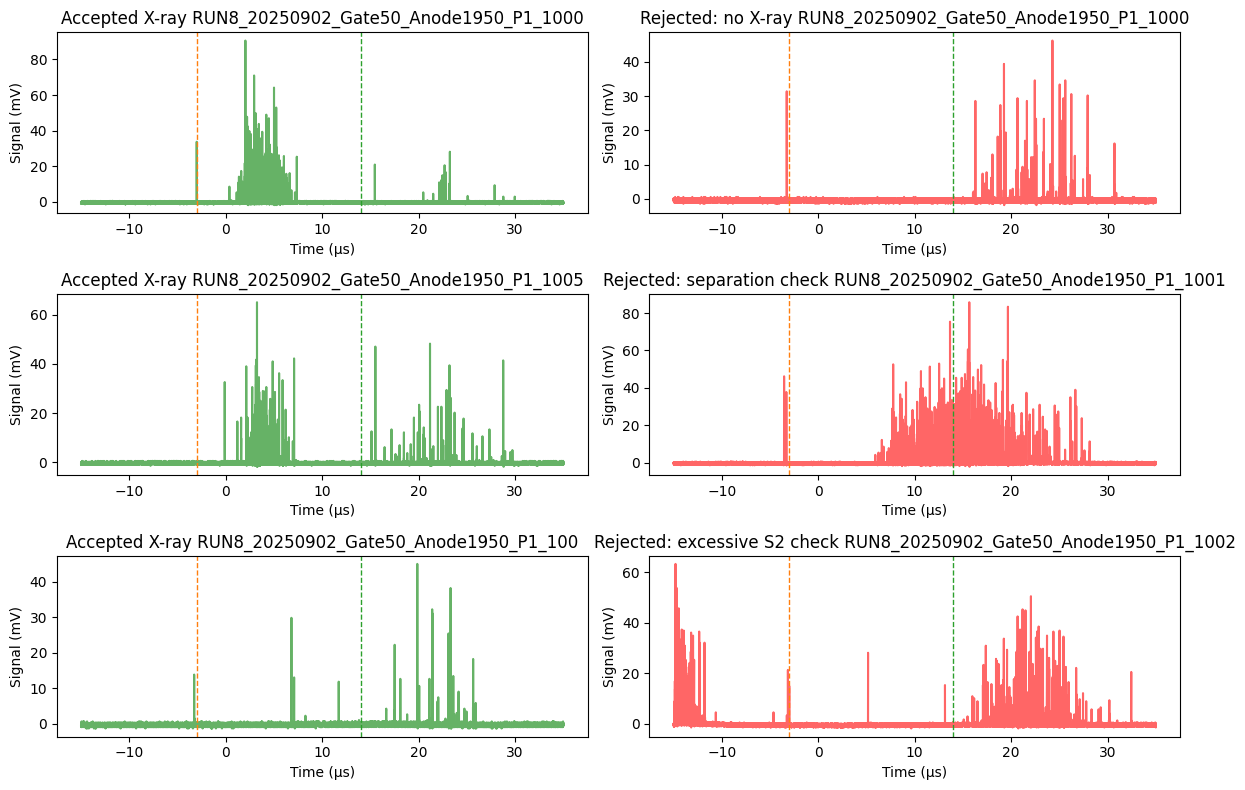

In [562]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8), )
plotting.plot_waveform(wfy, ax=ax[0,0], title='Accepted X-ray')
plotting.plot_waveform(wfn, ax=ax[0,1], title='Rejected: no X-ray', color='r')
plotting.plot_waveform(wfyy, ax=ax[1,0], title='Accepted X-ray')
plotting.plot_waveform(wfnn, ax=ax[1,1], title='Rejected: separation check', color='r')
plotting.plot_waveform(wfy3, ax=ax[2,0], title='Accepted X-ray')
plotting.plot_waveform(wfn3, ax=ax[2,1], title='Rejected: excessive S2 check', color='r')
for a in ax.flatten():
    a.axvline(t_s1, color='C1', ls='--', lw=1)
    a.axvline(s2_start, color='C2', ls='--', lw=1)
plt.tight_layout()

In [35]:
xres_test = xray_event_pipeline(wff, t_s1=t_s1, s2_start=s2_start, bs_threshold=2, max_area_s2=1e5,
                              dt = 2e-4, min_s2_sep=1, min_s1_sep=1)

# plotting.plot_waveform(pwf, title='Processed accepted X-ray')

# Test at set level

In [541]:
set_50 = constructors.set_from_dir(meas_path)

In [542]:
xres50 = classify_xrays_set(set_50, t_s1=t_s1, s2_start=s2_start, bs_threshold=2, max_area_s2=1e5,
                        min_s2_sep=1, min_s1_sep=1, dt=2e-4)

In [543]:
xareas = np.array([xr.area  for xff in xres50.events for xr in xff if xr.accepted])

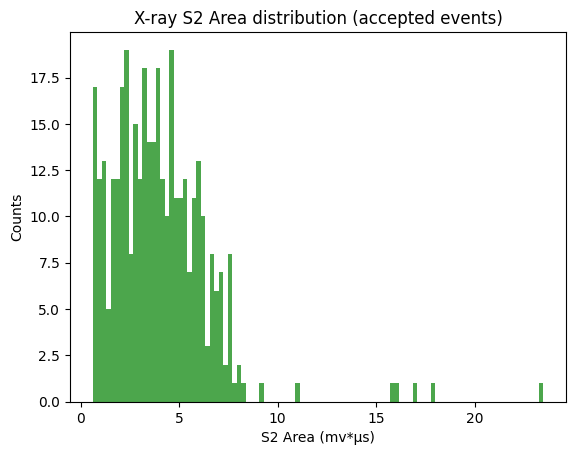

In [580]:
xcut = xareas[(xareas > 0.6) & (xareas < 30)]
plt.hist(xcut, bins=100, color='g', alpha=0.7);
plt.gca().set(xlabel='S2 Area (mv*µs)', ylabel='Counts', title='X-ray S2 Area distribution (accepted events)');

In [576]:
len(xcut)

712

In [41]:
np.mean(xcut) * 1000 # / 23.6  # phe/keV


np.float64(4006.866871516058)

In [44]:
W = 22  # eV
A_s2_xr = np.mean(xcut)
E_gamma = 12.3 * 1000  # eV, from https://www.nndc.bnl.gov/nudat3/decaysearchdirect.jsp?nuc=232Th&unc=NDS
N_e = E_gamma / W # electrons
g_s2 = A_s2_xr / N_e  # mV·µs/electron
g_s2, N_e

(np.float64(0.00716675375393116), 559.0909090909091)

In [45]:
A_s2_ra = 1 # mV·µs
N_e_ra = A_s2_ra / g_s2
E_ra = N_e_ra * W / 1000  # keV
E_ra, N_e_ra

(np.float64(3.069730139385966), np.float64(139.53318815390756))

# Test at run level

In [545]:
run8 = Run(
    root_directory = base_dir,
    run_id = "RUN8",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 1e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20                # µs 
)

run8 = constructors.populate_run(run8)
run8 = transport.with_gas_density(run8)

run8.gas_density

4.877421222922505e+19

In [546]:
def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=20, batch_size=20, flag_plot=False)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

run8 = replace(run8, sets=[prepare_set(s, run8) for s in run8.sets])

In [548]:
for set in run8.sets:
    print(set.metadata['t_s1'])

-8.158
-6.596
-4.016
-3.698
-4.269
-6.556
-6.52


In [549]:
for set in run8.sets:
    if set.metadata['t_s1'] < -3.7:
        set.metadata['t_s1'] = -3.6

In [553]:
intconfig_xrays = config.IntegrationConfig(
    bs_threshold = 2,          # mV
    max_area_s2 = 1e5,        # mV·µs
    min_s2_sep = 1,            # µs
    min_s1_sep = 1,            # µs
    n_pedestal = 200,          # samples
    ma_window = 10,            # samples
    dt = 2e-4,                    # ns
)
range_sets = slice(1, 5)
sets_to_process = run8.sets[range_sets] if range_sets is not None else run8.sets
for i, set_pmt in enumerate(sets_to_process):
    print(f'{i}, {set_pmt.source_dir}, {set_pmt.metadata["t_s1"]}, {set_pmt.time_drift}')

0, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000, -3.6, 15.137548167034852
1, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate200_Anode2100, -3.6, 13.209800817948338
2, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate300_Anode2200, -3.698, 12.430697144677039
3, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate400_Anode2300, -3.6, 11.834509826932996


In [554]:
results_run8 = classify_xrays_run(run8, ts2_tol = -0.2, range_sets=range_sets,
                                    config=intconfig_xrays)

Processing x-rays in set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000 in drift window: (-3.6, np.float64(11.337548167034853))
Processing x-rays in set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate200_Anode2100 in drift window: (-3.6, np.float64(9.409800817948339))
Processing x-rays in set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate300_Anode2200 in drift window: (np.float64(-3.698), np.float64(8.532697144677039))
Processing x-rays in set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate400_Anode2300 in drift window: (-3.6, np.float64(8.034509826932997))


In [556]:
range_sets = slice(5, 7)
sets_to_process = run8.sets[range_sets] if range_sets is not None else run8.sets
for i, set_pmt in enumerate(sets_to_process):
    print(f'{i}, {set_pmt.source_dir}, {set_pmt.metadata["t_s1"]}, {set_pmt.time_drift}')

0, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400, -3.6, 11.333863327602604
1, /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate600_Anode2500, -3.6, 10.90498318913292


In [557]:
results_run82 = classify_xrays_run(run8, ts2_tol = -0.2, range_sets=range_sets,
                                    config=intconfig_xrays)

Processing x-rays in set /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400 in drift window: (-3.6, np.float64(7.533863327602604))


PicklingError: Can't pickle <class 'RaTag.datatypes.XRayResults'>: it's not the same object as RaTag.datatypes.XRayResults

In [20]:
results_run5

{'FieldScan_5GSsec_Anode1950V_Gate50V': XRayResults(set_id=PosixPath('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V'), events=[XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_1245Wfm', accepted=False, reason='no signal above baseline', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_1514Wfm', accepted=False, reason='insufficient separation (t_pre_s2=19.76), (t_post_s1=0.01)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_4659Wfm', accepted=False, reason='no signal above baseline', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_7900Wfm', accepted=False, reason='insufficient separation (t_pre_s2=0.00), (t_post_s1=19.77)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_4108Wfm', accepted=False, reason='insufficient separation (t_pre_s2=0.18), (t_post_s1=19.59)', area=None), XRayEvent(wf_id='RUN5_26052025_Gate50_Anode1950_P7_8962Wfm', accepted=True, reason

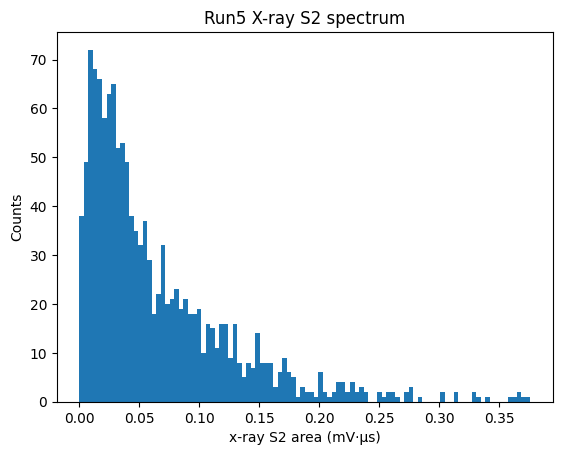

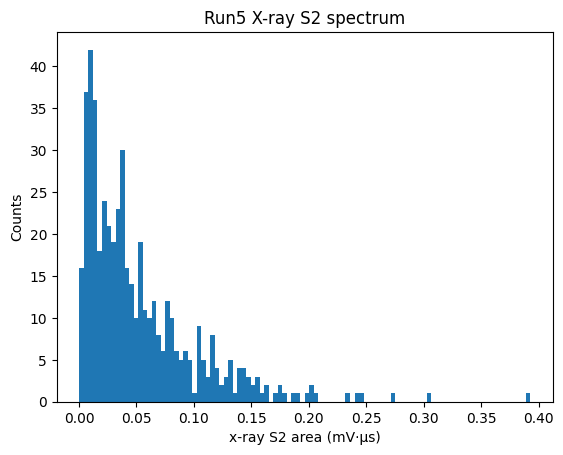

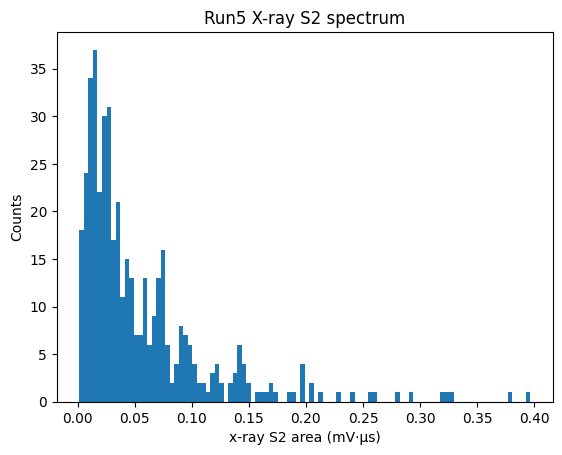

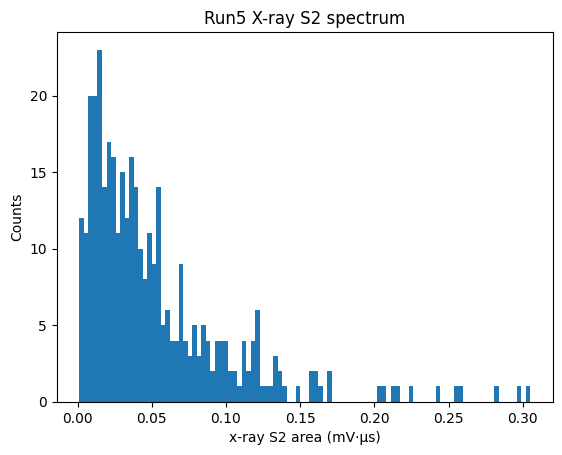

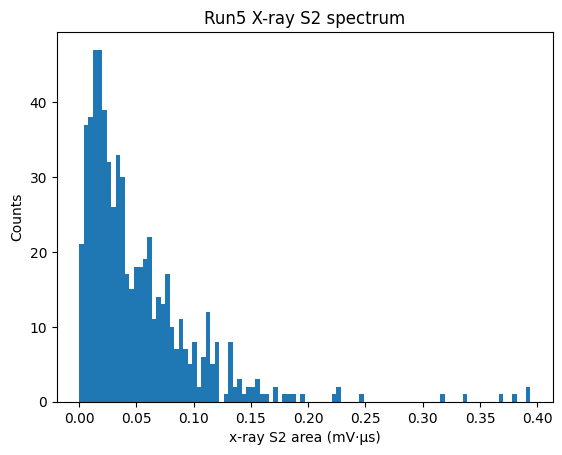

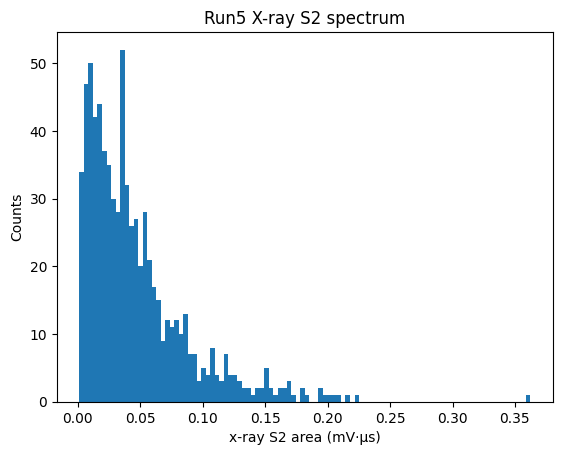

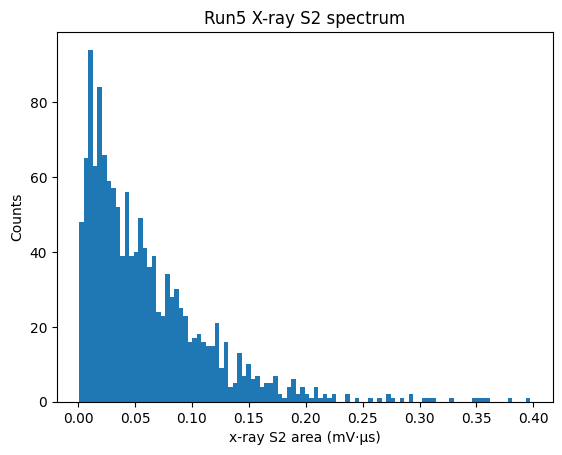

/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_26115/1750048622.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


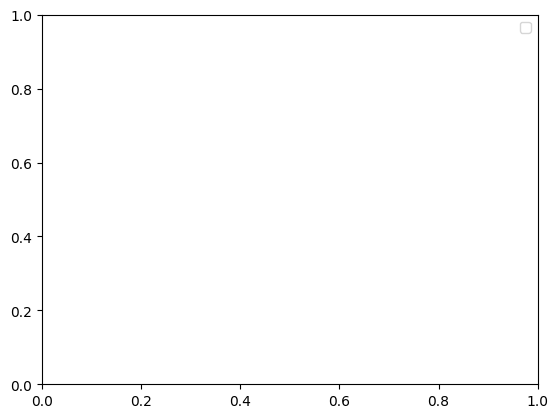

In [21]:
from matplotlib.pyplot import xlabel


for set_id, xr in results_run5.items():
    xareas = np.array([xr.area for xr in xr.events if xr.accepted])
    xcut = xareas[xareas < 0.4]
    plt.hist(xcut, bins=100, label=set_id);
    plt.gca().set(xlabel='x-ray S2 area (mV·µs)', ylabel='Counts', title='Run5 X-ray S2 spectrum');
    plt.show() 
plt.legend()